Epoch 0: Loss 4.8269
Epoch 100: Loss -0.1385
Epoch 200: Loss -0.5800
Epoch 300: Loss -0.7417
Epoch 400: Loss -0.5622
Epoch 500: Loss -0.9623
Epoch 600: Loss -0.8947
Epoch 700: Loss -0.9494
Epoch 800: Loss -0.8199
Epoch 900: Loss -0.9101
Epoch 1000: Loss -0.8513


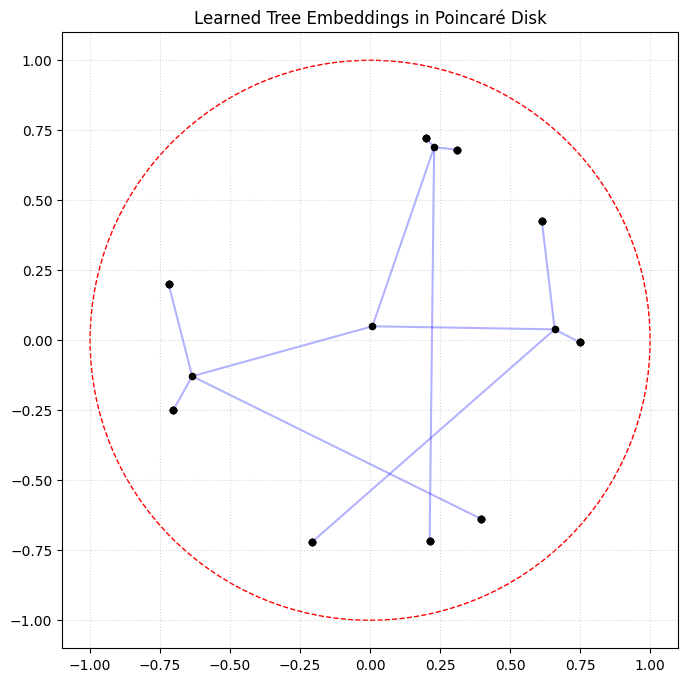

In [5]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class PoincareManifold:
    def __init__(self, c=1.0):
        self.c = c  

    def mobius_add(self, x, y):
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)
        num = (1 + 2 * self.c * xy + self.c * y2) * x + (1 - self.c * x2) * y
        denom = 1 + 2 * self.c * xy + self.c**2 * x2 * y2
        return num / torch.clamp(denom, min=1e-15)

    def exp_map(self, p, v):
        if isinstance(p, (int, float)) and p == 0:
            p = torch.zeros_like(v)
        v_norm = torch.norm(v, p=2, dim=-1, keepdim=True).clamp(min=1e-10)
        sqrt_c = np.sqrt(self.c)
        p_norm_sq = torch.sum(p * p, dim=-1, keepdim=True)
        lambda_p = 2 / (1 - self.c * p_norm_sq)
        v_at_origin = torch.tanh(sqrt_c * lambda_p * v_norm / 2) * v / (sqrt_c * v_norm)
        if torch.all(p == 0):
            return v_at_origin
        return self.mobius_add(p, v_at_origin)

    def log_map(self, p, x):
        x_transformed = self.mobius_add(-p, x)
        sqrt_c = np.sqrt(self.c)
        x_norm = torch.norm(x_transformed, p=2, dim=-1, keepdim=True).clamp(min=1e-10)
        p_norm_sq = torch.sum(p * p, dim=-1, keepdim=True)
        lambda_p = 2 / (1 - self.c * p_norm_sq)
        arg = (sqrt_c * x_norm).clamp(max=1 - 1e-7)
        scalar = (2 / (lambda_p * sqrt_c * x_norm)) * torch.atanh(arg)
        return scalar * x_transformed

    def dist(self, x, y):
        sq_dist = torch.norm(x - y, p=2, dim=-1)**2
        nx = 1 - self.c * torch.norm(x, p=2, dim=-1)**2
        ny = 1 - self.c * torch.norm(y, p=2, dim=-1)**2
        val = 1 + 2 * self.c * sq_dist / (nx.clamp(min=1e-15) * ny.clamp(min=1e-15))
        return (1 / np.sqrt(self.c)) * torch.acosh(val.clamp(min=1 + 1e-7))

    def project(self, x):
        norm = torch.norm(x, p=2, dim=-1, keepdim=True)
        max_norm = (1 - 1e-5) / np.sqrt(self.c)
        cond = norm >= max_norm
        projected = x / norm * max_norm
        return torch.where(cond, projected, x)

#####################################################################################################

class RiemannianEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, manifold):
        super().__init__()
        self.manifold = manifold
        self.weight = nn.Parameter(torch.randn(vocab_size, embed_dim) * 0.01)

    def forward(self, x):
        raw_vecs = self.weight[x]
        return self.manifold.exp_map(p=0, v=raw_vecs)

class MobiusLinear(nn.Module):
    def __init__(self, in_features, out_features, manifold):
        super().__init__()
        self.manifold = manifold
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x_tangent = self.manifold.log_map(p=torch.zeros_like(x), x=x)
        res_tangent = torch.matmul(x_tangent, self.weight.t())
        res_manifold = self.manifold.exp_map(p=torch.zeros_like(res_tangent), v=res_tangent)
        bias_manifold = self.manifold.exp_map(p=torch.zeros_like(self.bias), v=self.bias)
        return self.manifold.mobius_add(res_manifold, bias_manifold)

class PoincareAttention(nn.Module):
    def __init__(self, embed_dim, manifold):
        super().__init__()
        self.manifold = manifold
        self.scale = embed_dim ** 0.5

    def forward(self, Q, K, V):
        dists = self.manifold.dist(Q.unsqueeze(2), K.unsqueeze(1))
        attn_scores = torch.softmax(-dists**2 / self.scale, dim=-1)
        v_tangent = self.manifold.log_map(p=0, x=V)
        context_tangent = torch.einsum('bqk,bkd->bqd', attn_scores, v_tangent)
        return self.manifold.exp_map(p=0, v=context_tangent)

#####################################################################################################

class RSGD(torch.optim.Optimizer):
    def __init__(self, params, lr, manifold):
        defaults = dict(lr=lr, manifold=manifold)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None: loss = closure()
        for group in self.param_groups:
            manifold = group['manifold']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None: continue
                p_sq_norm = torch.sum(p.data**2, dim=-1, keepdim=True)
                rescale_factor = ((1 - manifold.c * p_sq_norm)**2) / 4
                riemannian_grad = p.grad.data * rescale_factor
                p.data = manifold.exp_map(p=p.data, v=-lr * riemannian_grad)
                p.data = manifold.project(p.data)
        return loss

#####################################################################################################

G = nx.balanced_tree(r=3, h=3)
nodes = list(G.nodes())
edge_index = torch.tensor(list(G.edges()), dtype=torch.long)

vocab_size = len(nodes)
embed_dim = 2
lr_manifold = 1.0  # High for embedding
manifold = PoincareManifold(c=1.0)

model = RiemannianEmbedding(vocab_size, embed_dim, manifold)

manifold_params = []
euclidean_params = []

for name, param in model.named_parameters():
    if 'weight' in name:
        manifold_params.append(param)
    else:
        euclidean_params.append(param)

optimizer_manifold = RSGD(manifold_params, lr=lr_manifold, manifold=manifold)
optimizer_euclidean = torch.optim.Adam(euclidean_params, lr=0.001) if euclidean_params else None

for epoch in range(1001):
    optimizer_manifold.zero_grad()
    if optimizer_euclidean: optimizer_euclidean.zero_grad()
    
    u_idx, v_idx = edge_index[:, 0], edge_index[:, 1]
    u_embed, v_embed = model(u_idx), model(v_idx)
    
    dist_pos = manifold.dist(u_embed, v_embed)
    
    random_idx = torch.randint(0, vocab_size, (u_idx.size(0),))
    dist_neg = manifold.dist(u_embed, model(random_idx))
    
    loss = dist_pos.mean() - 1.5 * torch.log(dist_neg.mean() + 1e-6)
    
    loss += 0.1 * manifold.dist(model(torch.tensor([0])), torch.zeros(1, 2)).mean()
    
    loss.backward()
    optimizer_manifold.step()
    if optimizer_euclidean: optimizer_euclidean.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

def plot_poincare_tree(model, edge_index):
    with torch.no_grad():
        embeddings = model.manifold.project(model.manifold.exp_map(p=0, v=model.weight)).cpu().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))
    circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linestyle='--', label='Boundary')
    ax.add_artist(circle)
    
    for i in range(edge_index.shape[0]):
        u_idx, v_idx = edge_index[i]
        u_pos, v_pos = embeddings[u_idx], embeddings[v_idx]
        ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='blue', alpha=0.3, zorder=1)
    
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c='black', s=20, zorder=2)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title("Learned Tree Embeddings in Poincaré Disk")
    plt.grid(True, which='both', linestyle=':', alpha=0.5)
    plt.show()

plot_poincare_tree(model, edge_index)